In [ ]:
#|default_exp forecast

In [ ]:
#|hide
%load_ext autoreload
%autoreload 2

# Forecast

> Full pipeline encapsulation

In [ ]:
#|export
from typing import Callable, Iterable, List, Optional, Union

import numpy as np
import pandas as pd
from sklearn.base import clone

from mlforecast.core import (
    DateFeature,
    Differences,
    Freq,
    LagTransforms,
    Lags,
    Models,
    TimeSeries,
)
from mlforecast.utils import backtest_splits

In [ ]:
#|hide
import warnings

from nbdev import show_doc
from sklearn import set_config

In [ ]:
#|hide
set_config(display='text')
warnings.simplefilter('ignore', UserWarning)

In [ ]:
#|export
class Forecast:
    """Feature engineering + model training + forecasting pipeline encapsulation."""
    
    def __init__(
        self,
        models: Models,
        freq: Optional[Freq] = None,
        lags: Optional[Lags] = None,
        lag_transforms: Optional[LagTransforms] = None,
        date_features: Optional[Iterable[DateFeature]] = None,
        differences: Optional[Differences] = None,
        num_threads: int = 1,
    ):
        """Create forecast object

        Parameters
        ----------
        models : regressor or list of regressors
            Models that will be trained and used to compute the forecasts.
        freq : str or int, optional (default=None)
            Pandas offset alias, e.g. 'D', 'W-THU' or integer denoting the frequency of the series.
        lags : list of int, optional (default=None)
            Lags of the target to use as features.
        lag_transforms : dict of int to list of functions, optional (default=None)
            Mapping of target lags to their transformations.
        date_features : list of str or callable, optional (default=None)
            Features computed from the dates. Can be pandas date attributes or functions that will take the dates as input.
        differences : list of int, optional (default=None)
            Differences to take of the target before computing the features. These are restored at the forecasting step.
        num_threads : int (default=1)
            Number of threads to use when computing the features.
        """        
        if not isinstance(models, list):
            models = [clone(models)]
        self.models = [clone(m) for m in models]
        self.ts = TimeSeries(freq, lags, lag_transforms, date_features, differences, num_threads)
        
    def __repr__(self):
        return (
            f'Forecast(models=[{", ".join(m.__class__.__name__ for m in self.models)}], '
            f'freq={self.freq}, '
            f'lag_features={list(self.ts.transforms.keys())}, '
            f'date_features={self.ts.date_features}, '
            f'num_threads={self.ts.num_threads})'
        )
    
    @property
    def freq(self):
        return self.ts.freq

    def preprocess(
        self,
        data: pd.DataFrame,
        id_col: str,
        time_col: str,
        target_col: str,
        static_features: Optional[List[str]] = None,
        dropna: bool = True,
        keep_last_n: Optional[int] = None,
    ) -> pd.DataFrame:
        """Add the features to `data`.
        
        Parameters
        ----------
        data : pandas DataFrame
            Series data in long format.
        id_col : str
            Column that identifies each serie. If 'index' then the index is used.
        time_col : str
            Column that identifies each timestep, its values can be timestamps or integers.
        target_col : str
            Column that contains the target.
        static_features : list of str, optional (default=None)
            Names of the features that are static and will be repeated when forecasting.
        dropna : bool (default=True)
            Drop rows with missing values produced by the transformations.
        keep_last_n : int, optional (default=None)
            Keep only these many records from each serie for the forecasting step. Can save time and memory if your features allow it.

        Returns
        -------
        result : pandas DataFrame.
            `data` plus added features.
        """
        return self.ts.fit_transform(data, id_col, time_col, target_col, static_features, dropna, keep_last_n)
    
    def fit_models(
        self,
        X: pd.DataFrame,
        y: Union[np.ndarray, pd.Series],
    ) -> 'Forecast':
        """Manually train models. Use this if you called `Forecast.preprocess` beforehand.
        
        Parameters
        ----------
        X : pandas DataFrame
            Features.
        y : numpy array or pandas Series.
            Target.
            
        Returns
        -------
        self : Forecast
            Forecast object with trained models.
        """
        self.models_ = []
        for i, model in enumerate(self.models):
            self.models_.append(clone(model).fit(X, y))
        return self

    def fit(
        self,
        data: pd.DataFrame,
        id_col: str,
        time_col: str,
        target_col: str,
        static_features: Optional[List[str]] = None,
        dropna: bool = True,
        keep_last_n: Optional[int] = None,
    ) -> 'Forecast':
        """Apply the feature engineering and train the models.
        
        Parameters
        ----------
        data : pandas DataFrame
            Series data in long format.
        id_col : str
            Column that identifies each serie. If 'index' then the index is used.
        time_col : str
            Column that identifies each timestep, its values can be timestamps or integers.
        target_col : str
            Column that contains the target.
        static_features : list of str, optional (default=None)
            Names of the features that are static and will be repeated when forecasting.
        dropna : bool (default=True)
            Drop rows with missing values produced by the transformations.
        keep_last_n : int, optional (default=None)
            Keep only these many records from each serie for the forecasting step. Can save time and memory if your features allow it.

        Returns
        -------
        self : Forecast
            Forecast object with series values and trained models.
        """
        series_df = self.preprocess(data, id_col, time_col, target_col, static_features, dropna, keep_last_n)
        X, y = series_df.drop(columns=[time_col, target_col]), series_df[target_col].values
        del series_df
        return self.fit_models(X, y)

    def predict(
        self,
        horizon: int,
        dynamic_dfs: Optional[List[pd.DataFrame]] = None,
        predict_fn: Optional[Callable] = None,
        **predict_fn_kwargs,
    ) -> pd.DataFrame:
        """Compute the predictions for the next `horizon` steps.
        
        Parameters
        ----------
        horizon : int
            Number of periods to predict.
        dynamic_dfs : list of pandas DataFrame, optional (default=None)
            Future values of the dynamic features, e.g. prices.
        predict_fn : callable, optional (default=None)
            Custom function to compute predictions.
            This function will recieve: model, new_x, dynamic_dfs, features_order and kwargs,
            and should return an array with the predictions, where:
                model : regressor
                    Fitted model.
                new_x : pandas DataFrame
                    Current values of the features.
                dynamic_dfs : list of pandas DataFrame
                    Future values of the dynamic features
                features_order : list of str
                    Column names in the order in which they were used to train the model.
                **kwargs
                    Other keyword arguments passed to `Forecast.predict`.
        **predict_fn_kwargs
            Additional arguments passed to predict_fn
                    
        Returns
        -------
        result : pandas DataFrame
            Predictions for each serie and timestep, with one column per model.
        """
        if not hasattr(self, 'models_'):
            raise ValueError('No fitted models found. You have to call fit or preprocess + fit_models.')
        return self.ts.predict(
            self.models_, horizon, dynamic_dfs, predict_fn, **predict_fn_kwargs
        )

    def cross_validation(
        self,
        data: pd.DataFrame,
        n_windows: int,
        window_size: int,
        id_col: str,
        time_col: str,
        target_col: str,
        static_features: Optional[List[str]] = None,
        dropna: bool = True,
        keep_last_n: Optional[int] = None,
        dynamic_dfs: Optional[List[pd.DataFrame]] = None,
        predict_fn: Optional[Callable] = None,
        **predict_fn_kwargs,
    ):
        """Perform time series cross validation.
        Creates `n_windows` splits where each window has `window_size` test periods, 
        trains the models, computes the predictions and merges the actuals.
        
        Parameters
        ----------
        data : pandas DataFrame
            Series data in long format.
        n_windows : int
            Number of windows to evaluate.
        window_size : int
            Number of test periods in each window.
        id_col : str
            Column that identifies each serie. If 'index' then the index is used.
        time_col : str
            Column that identifies each timestep, its values can be timestamps or integers.
        target_col : str
            Column that contains the target.
        static_features : list of str, optional (default=None)
            Names of the features that are static and will be repeated when forecasting.
        dropna : bool (default=True)
            Drop rows with missing values produced by the transformations.
        keep_last_n : int, optional (default=None)
            Keep only these many records from each serie for the forecasting step. Can save time and memory if your features allow it.
        dynamic_dfs : list of pandas DataFrame, optional (default=None)
            Future values of the dynamic features, e.g. prices.
        predict_fn : callable, optional (default=None)
            Custom function to compute predictions.
            This function will recieve: model, new_x, dynamic_dfs, features_order and kwargs,
            and should return an array with the predictions, where:
                model : regressor
                    Fitted model.
                new_x : pandas DataFrame
                    Current values of the features.
                dynamic_dfs : list of pandas DataFrame
                    Future values of the dynamic features
                features_order : list of str
                    Column names in the order in which they were used to train the model.
                **kwargs
                    Other keyword arguments passed to `Forecast.predict`.
        **predict_fn_kwargs
            Additional arguments passed to predict_fn                    

        Returns
        -------
        result : pandas DataFrame
            Predictions for each window with the series id, timestamp, last train date, target value and predictions from each model.
        """
        results = []
        self.cv_models_ = []
        if id_col != 'index':
            data = data.set_index(id_col)
        
        if np.issubdtype(data[time_col].dtype.type, np.integer):
            freq = 1
        else:
            freq = self.freq

        for train_end, train, valid in backtest_splits(data, n_windows, window_size, freq, time_col, target_col):
            self.fit(train, 'index', time_col, target_col, static_features, dropna, keep_last_n)
            self.cv_models_.append(self.models_)
            y_pred = self.predict(
                window_size, dynamic_dfs, predict_fn, **predict_fn_kwargs
            )
            y_pred = y_pred.set_index(time_col, append=True)
            result = valid.set_index(time_col, append=True)[[target_col]].copy()
            result = result.join(y_pred).reset_index(time_col)
            result['cutoff'] = train_end            
            results.append(result)

        out = pd.concat(results)
        out = out[[time_col, 'cutoff', target_col, *y_pred.columns]]
        if id_col != 'index':
            out = out.reset_index()
        return out

In [ ]:
show_doc(Forecast)

---

### Forecast

>      Forecast (models:Union[sklearn.base.BaseEstimator,List[sklearn.base.BaseE
>                stimator]], freq:Union[int,str,NoneType]=None,
>                lags:Optional[Iterable[int]]=None, lag_transforms:Optional[Dict
>                [int,List[Union[Callable,Tuple[Callable,Any]]]]]=None,
>                date_features:Optional[Iterable[Union[str,Callable]]]=None,
>                differences:Optional[Iterable[int]]=None, num_threads:int=1)

Feature engineering + model training + forecasting pipeline encapsulation.

The `Forecast` class is a high level abstraction that encapsulates all the steps in the pipeline (preprocessing, fitting the model and computing the predictions). It tries to mimic the scikit-learn API.

## Example
This shows an example with just 4 series of the M4 dataset. If you want to run it yourself on all of them, you can refer to [this notebook](https://www.kaggle.com/code/lemuz90/m4-competition).

In [ ]:
import random

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from datasetsforecast.m4 import M4, M4Info
from sklearn.metrics import mean_squared_error
from window_ops.ewm import ewm_mean
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean

from mlforecast.utils import generate_daily_series, generate_prices_for_series

In [ ]:
group = 'Hourly'
await M4.async_download('data', group=group)
df, *_ = M4.load(directory='data', group=group)
df['ds'] = df['ds'].astype('int')
ids = df['unique_id'].unique()
random.seed(0)
sample_ids = random.choices(ids, k=4)
sample_df = df[df['unique_id'].isin(sample_ids)]
sample_df

,unique_id,ds,y
86796,H196,1,11.8
86797,H196,2,11.4
86798,H196,3,11.1
86799,H196,4,10.8
86800,H196,5,10.6
...,...,...,...
325235,H413,1004,99.0
325236,H413,1005,88.0
325237,H413,1006,47.0
325238,H413,1007,41.0


We now split this data into train and validation.

In [ ]:
info = M4Info[group]
horizon = info.horizon
valid = sample_df.groupby('unique_id').tail(horizon)
train = sample_df.drop(valid.index)
train.shape, valid.shape

((3840, 3), (192, 3))

### Creating the Forecast object

The forecast object encapsulates the feature engineering + training the models + forecasting. When we initialize it we define:
* The models we want to train
* The series frequency. This is added to the last dates seen in train for the forecast step, if the time column contains integer values we can leave it empty or set it to 1.
* The feature engineering:
    * Lags to use as features
    * Transformations on the lags
    * Date features
    * Differences to apply to the target before computing the features, which are then restored when forecasting.
* Number of threads to use when computing the features.

In [ ]:
fcst = Forecast(
    models=lgb.LGBMRegressor(random_state=0),
    differences=[24],
    lags=[24 * (i+1) for i in range(7)],
    lag_transforms={
        48: [(ewm_mean, 0.3)],
    },
    num_threads=1,
)
fcst

Forecast(models=[LGBMRegressor], freq=1, lag_features=['lag-24', 'lag-48', 'lag-72', 'lag-96', 'lag-120', 'lag-144', 'lag-168', 'ewm_mean_lag-48_alpha-0.3'], date_features=[], num_threads=1)

Once we have this setup we can compute the features and fit the model.

In [ ]:
show_doc(Forecast.fit)

---

### Forecast.fit

>      Forecast.fit (data:pandas.core.frame.DataFrame, id_col:str, time_col:str,
>                    target_col:str, static_features:Optional[List[str]]=None,
>                    dropna:bool=True, keep_last_n:Optional[int]=None)

Apply the feature engineering and train the models.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| data | DataFrame |  | Series data in long format. |
| id_col | str |  | Column that identifies each serie. If 'index' then the index is used. |
| time_col | str |  | Column that identifies each timestep, its values can be timestamps or integers. |
| target_col | str |  | Column that contains the target. |
| static_features | typing.Optional[typing.List[str]] | None | Names of the features that are static and will be repeated when forecasting. |
| dropna | bool | True | Drop rows with missing values produced by the transformations. |
| keep_last_n | typing.Optional[int] | None | Keep only these many records from each serie for the forecasting step. Can save time and memory if your features allow it. |
| **Returns** | **Forecast** |  | **Forecast object with series values and trained models.** |

In [ ]:
fcst.fit(train, id_col='unique_id', time_col='ds', target_col='y');

Once we've run this we're ready to compute our predictions.

In [ ]:
show_doc(Forecast.predict)

---

### Forecast.predict

>      Forecast.predict (horizon:int,
>                        dynamic_dfs:Optional[List[pandas.core.frame.DataFrame]]
>                        =None, predict_fn:Optional[Callable]=None,
>                        **predict_fn_kwargs)

Compute the predictions for the next `horizon` steps.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| horizon | int |  | Number of periods to predict. |
| dynamic_dfs | typing.Optional[typing.List[pandas.core.frame.DataFrame]] | None | Future values of the dynamic features, e.g. prices. |
| predict_fn | typing.Optional[typing.Callable] | None | Custom function to compute predictions.<br>This function will recieve: model, new_x, dynamic_dfs, features_order and kwargs,<br>and should return an array with the predictions, where:<br>    model : regressor<br>        Fitted model.<br>    new_x : pandas DataFrame<br>        Current values of the features.<br>    dynamic_dfs : list of pandas DataFrame<br>        Future values of the dynamic features<br>    features_order : list of str<br>        Column names in the order in which they were used to train the model.<br>    **kwargs<br>        Other keyword arguments passed to `Forecast.predict`. |
| predict_fn_kwargs |  |  |  |
| **Returns** | **DataFrame** |  | **Predictions for each serie and timestep, with one column per model.** |

In [ ]:
predictions = fcst.predict(horizon)

We can see at a couple of results.

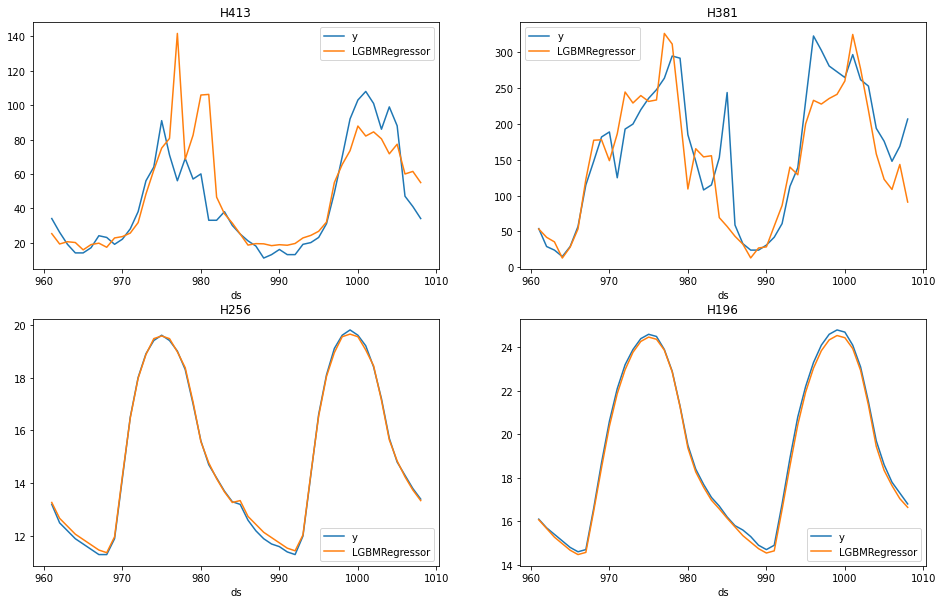

In [ ]:
results = valid.merge(predictions, on=['unique_id', 'ds']).set_index('unique_id')
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
for uid, axi in zip(sample_ids, ax.flat):
    results.loc[uid].set_index('ds').plot(ax=axi, title=uid)

If you want to take a look at the data that will be used to train the models you can call `Forecast.preprocess`.

In [ ]:
show_doc(Forecast.preprocess)

---

### Forecast.preprocess

>      Forecast.preprocess (data:pandas.core.frame.DataFrame, id_col:str,
>                           time_col:str, target_col:str,
>                           static_features:Optional[List[str]]=None,
>                           dropna:bool=True, keep_last_n:Optional[int]=None)

Add the features to `data`.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| data | DataFrame |  | Series data in long format. |
| id_col | str |  | Column that identifies each serie. If 'index' then the index is used. |
| time_col | str |  | Column that identifies each timestep, its values can be timestamps or integers. |
| target_col | str |  | Column that contains the target. |
| static_features | typing.Optional[typing.List[str]] | None | Names of the features that are static and will be repeated when forecasting. |
| dropna | bool | True | Drop rows with missing values produced by the transformations. |
| keep_last_n | typing.Optional[int] | None | Keep only these many records from each serie for the forecasting step. Can save time and memory if your features allow it. |
| **Returns** | **DataFrame** |  | **`data` plus added features.** |

In [ ]:
prep_df = fcst.preprocess(train, id_col='unique_id', time_col='ds', target_col='y')
prep_df

,ds,y,lag-24,lag-48,lag-72,lag-96,lag-120,lag-144,lag-168,ewm_mean_lag-48_alpha-0.3
unique_id,,,,,,,,,,
H196,193,0.1,0.0,0.0,0.0,0.3,0.1,0.1,0.3,0.002810
H196,194,0.1,-0.1,0.1,0.0,0.3,0.1,0.1,0.3,0.031967
H196,195,0.1,-0.1,0.1,0.0,0.3,0.1,0.2,0.1,0.052377
H196,196,0.1,0.0,0.0,0.0,0.3,0.2,0.1,0.2,0.036664
H196,197,0.0,0.0,0.0,0.1,0.2,0.2,0.1,0.2,0.025665
...,...,...,...,...,...,...,...,...,...,...
H413,956,0.0,10.0,1.0,6.0,-53.0,44.0,-21.0,21.0,7.963225
H413,957,9.0,10.0,10.0,-7.0,-46.0,27.0,-19.0,24.0,8.574257
H413,958,16.0,8.0,5.0,-9.0,-36.0,32.0,-13.0,8.0,7.501980


If we do this we then have to call `Forecast.fit_models`, since this only stores the series information.

In [ ]:
show_doc(Forecast.fit_models)

---

### Forecast.fit_models

>      Forecast.fit_models (X:pandas.core.frame.DataFrame,
>                           y:Union[numpy.ndarray,pandas.core.series.Series])

Manually train models. Use this if you called `Forecast.preprocess` beforehand.

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| X | DataFrame | Features. |
| y | typing.Union[numpy.ndarray, pandas.core.series.Series] | Target. |
| **Returns** | **Forecast** | **Forecast object with trained models.** |

In [ ]:
X, y = prep_df.drop(columns=['ds', 'y']), prep_df['y']
fcst.fit_models(X, y)

Forecast(models=[LGBMRegressor], freq=1, lag_features=['lag-24', 'lag-48', 'lag-72', 'lag-96', 'lag-120', 'lag-144', 'lag-168', 'ewm_mean_lag-48_alpha-0.3'], date_features=[], num_threads=1)

In [ ]:
predictions2 = fcst.predict(horizon)
pd.testing.assert_frame_equal(predictions, predictions2)

### Cross validation

If we would like to know how good our forecast will be for a specific model and set of features then we can perform cross validation. What cross validation does is take our data and split it in two parts, where the first part is used for training and the second one for validation. Since the data is time dependant we usually take the last *x* observations from our data as the validation set.

This process is implemented in `Forecast.cross_validation`, which takes our data and performs the process described above for `n_windows` times where each window has `window_size` validation samples in it. For example, if we have 100 samples and we want to perform 2 backtests each of size 14, the splits will be as follows:

1. Train: 1 to 72. Validation: 73 to 86.
2. Train: 1 to 86. Validation: 87 to 100.

In [ ]:
show_doc(Forecast.cross_validation)

---

### Forecast.cross_validation

>      Forecast.cross_validation (data:pandas.core.frame.DataFrame,
>                                 n_windows:int, window_size:int, id_col:str,
>                                 time_col:str, target_col:str,
>                                 static_features:Optional[List[str]]=None,
>                                 dropna:bool=True,
>                                 keep_last_n:Optional[int]=None, dynamic_dfs:Op
>                                 tional[List[pandas.core.frame.DataFrame]]=None
>                                 , predict_fn:Optional[Callable]=None,
>                                 **predict_fn_kwargs)

Perform time series cross validation.
Creates `n_windows` splits where each window has `window_size` test periods, 
trains the models, computes the predictions and merges the actuals.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| data | DataFrame |  | Series data in long format. |
| n_windows | int |  | Number of windows to evaluate. |
| window_size | int |  | Number of test periods in each window. |
| id_col | str |  | Column that identifies each serie. If 'index' then the index is used. |
| time_col | str |  | Column that identifies each timestep, its values can be timestamps or integers. |
| target_col | str |  | Column that contains the target. |
| static_features | typing.Optional[typing.List[str]] | None | Names of the features that are static and will be repeated when forecasting. |
| dropna | bool | True | Drop rows with missing values produced by the transformations. |
| keep_last_n | typing.Optional[int] | None | Keep only these many records from each serie for the forecasting step. Can save time and memory if your features allow it. |
| dynamic_dfs | typing.Optional[typing.List[pandas.core.frame.DataFrame]] | None | Future values of the dynamic features, e.g. prices. |
| predict_fn | typing.Optional[typing.Callable] | None | Custom function to compute predictions.<br>This function will recieve: model, new_x, dynamic_dfs, features_order and kwargs,<br>and should return an array with the predictions, where:<br>    model : regressor<br>        Fitted model.<br>    new_x : pandas DataFrame<br>        Current values of the features.<br>    dynamic_dfs : list of pandas DataFrame<br>        Future values of the dynamic features<br>    features_order : list of str<br>        Column names in the order in which they were used to train the model.<br>    **kwargs<br>        Other keyword arguments passed to `Forecast.predict`. |
| predict_fn_kwargs |  |  |  |
| **Returns** | **pandas DataFrame** |  | **Predictions for each window with the series id, timestamp, last train date, target value and predictions from each model.** |

In [ ]:
cv_results = fcst.cross_validation(
    train,
    n_windows=4,
    window_size=horizon,
    id_col='unique_id',
    time_col='ds',
    target_col='y',
)
cv_results

,unique_id,ds,cutoff,y,LGBMRegressor
0,H196,769,768,15.2,15.182273
1,H196,770,768,14.8,14.782273
2,H196,771,768,14.4,14.482273
3,H196,772,768,14.1,14.182273
4,H196,773,768,13.8,13.882273
...,...,...,...,...,...
763,H413,956,912,59.0,71.604298
764,H413,957,912,58.0,76.396233
765,H413,958,912,53.0,34.950008
766,H413,959,912,38.0,49.825492


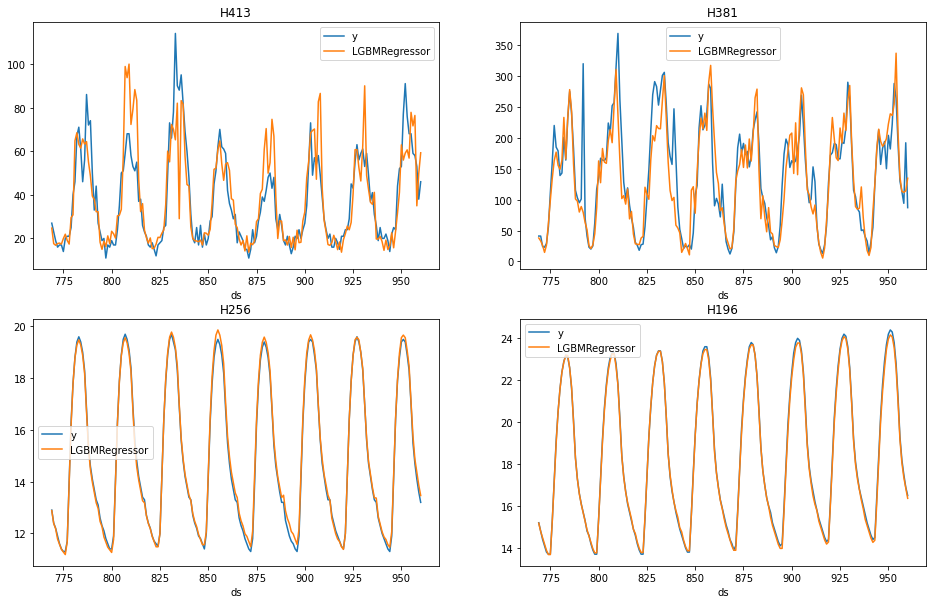

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

for uid, axi in zip(sample_ids, ax.flat):
    subset = cv_results[cv_results['unique_id'].eq(uid)].drop(columns=['unique_id', 'cutoff'])
    subset.set_index('ds').plot(ax=axi, title=uid)

### Dynamic features

We're going to use a synthetic dataset from this point onwards to demonstrate some other functionalities regarding external regressors.

In [ ]:
series = generate_daily_series(100, equal_ends=True, n_static_features=2, static_as_categorical=False)
series

,ds,y,static_0,static_1
unique_id,,,,
id_00,2000-10-05,3.981198,79,45
id_00,2000-10-06,10.327401,79,45
id_00,2000-10-07,17.657474,79,45
id_00,2000-10-08,25.898790,79,45
id_00,2000-10-09,34.494040,79,45
...,...,...,...,...
id_99,2001-05-10,45.340051,69,35
id_99,2001-05-11,3.022948,69,35
id_99,2001-05-12,10.131371,69,35


As we saw in the previous example, the required columns are the series identifier, time and target. Whatever extra columns you have, like `static_0` and `static_1` here are considered to be static and are replicated when constructing the features for the next timestamp. You can disable this by passing `static_features` to `Forecast.preprocess` or `Forecast.fit` , which will only keep the columns you define there as static. Keep in mind that they will still be used for training, so you'll have to provide them to `Forecast.predict` through the `dynamic_dfs` argument.

By default the predict method repeats the static features and updates the transformations and the date features. If you have dynamic features like prices or a calendar with holidays you can pass them as a list to the `dynamic_dfs` argument of `Forecast.predict`, which will call `pd.DataFrame.merge` on each of them in order.

Here's an example:

Suppose that we have a `product_id` column and we have a catalog for prices based on that `product_id` and the date.

In [ ]:
dynamic_series = series.rename(columns={'static_1': 'product_id'})
prices_catalog = generate_prices_for_series(dynamic_series)
prices_catalog

,ds,product_id,price
0,2000-06-09,1,0.548814
1,2000-06-10,1,0.715189
2,2000-06-11,1,0.602763
3,2000-06-12,1,0.544883
4,2000-06-13,1,0.423655
...,...,...,...
20180,2001-05-17,99,0.223520
20181,2001-05-18,99,0.446104
20182,2001-05-19,99,0.044783
20183,2001-05-20,99,0.483216


And you have already merged these prices into your series dataframe.

In [ ]:
series_with_prices = dynamic_series.reset_index().merge(prices_catalog, how='left')
series_with_prices.set_index('unique_id', inplace=True)
series_with_prices

,ds,y,static_0,product_id,price
unique_id,,,,,
id_00,2000-10-05,3.981198,79,45,0.570826
id_00,2000-10-06,10.327401,79,45,0.260562
id_00,2000-10-07,17.657474,79,45,0.274048
id_00,2000-10-08,25.898790,79,45,0.433878
id_00,2000-10-09,34.494040,79,45,0.653738
...,...,...,...,...,...
id_99,2001-05-10,45.340051,69,35,0.792152
id_99,2001-05-11,3.022948,69,35,0.782687
id_99,2001-05-12,10.131371,69,35,0.019463


This dataframe will be passed to `Forecast.fit` (or `Forecast.preprocess`), however since the price is dynamic we have to tell that method that only `static_0` and `product_id` are static and we'll have to update `price` in every timestep, which basically involves merging the updated features with the prices catalog.

In [ ]:
def even_day(dates):
    return dates.day % 2 == 0

models = [
    lgb.LGBMRegressor(n_jobs=1, random_state=0),
    xgb.XGBRegressor(n_jobs=1, random_state=0),
]
fcst = Forecast(
    models,
    freq='D',
    lags=[7],
    lag_transforms={
        1: [expanding_mean],
        7: [(rolling_mean, 14)]
    },
    date_features=['dayofweek', 'month', even_day],
    num_threads=2,
)
fcst.fit(
    series_with_prices,
    id_col='index',
    time_col='ds',
    target_col='y',
    static_features=['static_0', 'product_id'],
)

Forecast(models=[LGBMRegressor, XGBRegressor], freq=<Day>, lag_features=['lag-7', 'expanding_mean_lag-1', 'rolling_mean_lag-7_window_size-14'], date_features=['dayofweek', 'month', <function even_day>], num_threads=2)

The features used for training are stored in `Forecast.ts.features_order_`, as you can see `price` was used for training.

In [ ]:
fcst.ts.features_order_

['static_0',
 'product_id',
 'price',
 'lag-7',
 'expanding_mean_lag-1',
 'rolling_mean_lag-7_window_size-14',
 'dayofweek',
 'month',
 'even_day']

So in order to update the price in each timestep we just call `Forecast.predict` with our forecast horizon and pass the prices catalog as a dynamic dataframe.

In [ ]:
preds = fcst.predict(7, dynamic_dfs=[prices_catalog])
preds

,ds,LGBMRegressor,XGBRegressor
unique_id,,,
id_00,2001-05-15,42.184358,43.174004
id_00,2001-05-16,50.186606,50.842575
id_00,2001-05-17,1.940786,1.911936
id_00,2001-05-18,10.432289,9.788165
id_00,2001-05-19,18.701071,18.377850
...,...,...,...
id_99,2001-05-17,44.311743,43.611797
id_99,2001-05-18,1.909511,1.922798
id_99,2001-05-19,9.067718,8.772107


In [ ]:
#|hide
preds2 = fcst.predict(7, dynamic_dfs=[prices_catalog])

pd.testing.assert_frame_equal(preds, preds2)

In [ ]:
#|hide
non_std_series = series.copy()
non_std_series['ds'] = non_std_series.groupby('unique_id').cumcount()
non_std_series = non_std_series.reset_index().rename(columns={'unique_id': 'some_id', 'ds': 'time', 'y': 'value'})
flow_params = dict(
    models=models,
    lags=[7],
    lag_transforms={
        1: [expanding_mean],
        7: [(rolling_mean, 14)]
    },
    num_threads=2,
)
fcst = Forecast(**flow_params)
non_std_preds = fcst.fit(non_std_series, id_col='some_id', time_col='time', target_col='value').predict(7)
non_std_preds.index.name = 'unique_id'
fcst = Forecast(freq='D', **flow_params)
preds = fcst.fit(series, id_col='index', time_col='ds', target_col='y').predict(7)
pd.testing.assert_frame_equal(preds.drop(columns='ds'), non_std_preds.drop(columns='time'))

### Custom predictions
As you may have noticed `Forecast.predict` can take a `predict_fn` and `predict_fn_kwargs`. By default the predict method repeats the static features and updates the transformations and the date features. If you have dynamic features you can pass them as a list to `Forecast.predict` in the `dynamic_dfs` argument. However, if you want to do something else, you can define your own function which will take:

* The trained model.
* The updated features (static + transformations + date features).
* A list of dataframes with the dynamic features.
* The order of the features the model was trained on.
* Additional keyword arguments passed to `Forecast.predict`.

Here's an example:

Suppose that we want to scale our predictions so that our series are updated with these scaled values. We can achieve that with the following.

In [ ]:
def scaling_predict_fn(
    model,
    new_x,
    dynamic_dfs,
    features_order,
    scale_factor,
) -> np.ndarray:
    new_x = new_x[features_order]
    predictions = model.predict(new_x)
    return scale_factor * predictions

And now we just pass this function to `Forecast.predict`.

In [ ]:
fcst = Forecast(models, freq='D', lags=[7])
fcst.fit(series, id_col='index', time_col='ds', target_col='y')

scale_factor = 1.1
preds = fcst.predict(2, predict_fn=scaling_predict_fn, scale_factor=scale_factor)
preds

,ds,LGBMRegressor,XGBRegressor
unique_id,,,
id_00,2001-05-15,46.298462,47.070534
id_00,2001-05-16,54.772835,55.468819
id_01,2001-05-15,12.808338,12.969510
id_01,2001-05-16,16.426544,16.559385
id_02,2001-05-15,16.339826,16.399563
...,...,...,...
id_97,2001-05-16,38.865211,39.316402
id_98,2001-05-15,8.268328,8.267344
id_98,2001-05-16,10.476819,10.496795


In [ ]:
#|hide
fcst.ts._predict_setup()

for attr in ('head', 'tail'):
    new_x = fcst.ts._update_features().drop(columns='ds')
    original_preds = fcst.models_[0].predict(new_x)
    
    expected = scale_factor * original_preds
    actual = getattr(preds.groupby('unique_id')[models[0].__class__.__name__], attr)(1).values
    np.testing.assert_equal(expected, actual)
    
    fcst.ts._update_y(actual)

In [ ]:
#|hide
n_windows = 2
window_size = 14
fcst = Forecast(lgb.LGBMRegressor(), freq='D', lags=[7, 14])
backtest_results = fcst.cross_validation(
    non_std_series,
    n_windows,
    window_size,
    id_col='some_id',
    time_col='time',
    target_col='value',
    static_features=['static_0', 'static_1'],
)
renamer = {'some_id': 'unique_id', 'time': 'ds', 'value': 'y'}
backtest_results = backtest_results.rename(columns=renamer).set_index('unique_id')
renamed = non_std_series.rename(columns=renamer).set_index('unique_id')
manual_results = []
for cutoff, train, valid in backtest_splits(renamed, n_windows, window_size, 1):
    fcst.fit(
        train,
        id_col='index',
        time_col='ds',
        target_col='y',
        static_features=['static_0', 'static_1'],
    )
    pred = fcst.predict(window_size)
    res = valid[['ds', 'y']].copy()
    res['cutoff'] = cutoff
    res = res[['ds', 'cutoff', 'y']].copy()
    manual_results.append(res.merge(pred, on=['unique_id', 'ds'], how='left'))
manual_results = pd.concat(manual_results)
pd.testing.assert_frame_equal(backtest_results, manual_results)